In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.ops import index_update, index
from jax.scipy.special import expit as sigmoid
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import MissingInputsGP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [2]:
# Define test function
f, p_x, dim, lb, ub = branin()

# Problem settings
N = 25
noise = 0.0
options = {'kernel': 'RBF',
           'criterion': 'LW-LCB', 
           'input_prior': p_x,
           'kappa': 2.0,
           'nIter': 20}
active_dims = [0]
missing_dims = [1]
layers = [len(missing_dims), 20, 20, len(missing_dims)]
gp_model = MissingInputsGP(options, missing_dims, layers)

# Domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.normal(y.shape)

# Test data
create_plots = True
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                         YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Deliberately ommit inputs and concatenate with random values
X_true = X
Xm = lb[missing_dims] + (ub[missing_dims] - lb[missing_dims])*lhs(len(missing_dims), N)
X = index_update(X, index[:,missing_dims], Xm)

/Users/paris/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
rng_key = random.PRNGKey(0)
# Fetch normalized training data
norm_batch, norm_const = normalize(X, y, bounds)

# Train GP model
print('Train GP...')
rng_key = random.split(rng_key)[0]
opt_params = gp_model.train(norm_batch,
                            rng_key,
                            num_restarts = 10)

Train GP...


In [4]:
# Test accuracy
kwargs = {'params': opt_params,
              'batch': norm_batch,
              'norm_const': norm_const,
              'bounds': bounds,
              'gmm_vars': None}
mean, std = gp_model.predict(X_star, **kwargs)
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 1.503680e+00


In [5]:
Xnb = norm_batch['X']
nn_params = gp_model.unravel(opt_params[gp_model.nn_params_ids])
Xm_pred = lb[missing_dims] + (ub[missing_dims] - lb[missing_dims])*sigmoid(gp_model.net_apply(nn_params, Xnb[:,missing_dims]))
# print(Xm_pred)
X = index_update(X, index[:,missing_dims], Xm_pred)

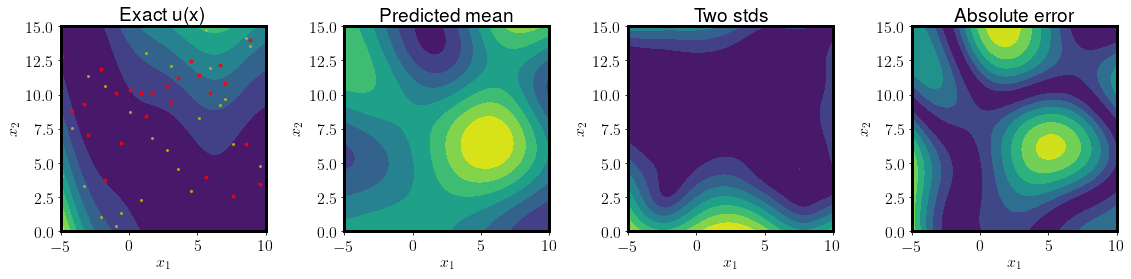

In [6]:
# Convert to NumPy
X_star = onp.array(X_star)
y_star = onp.array(y_star)
mean = onp.array(mean)
std = onp.array(std)
XX = onp.array(XX)
YY = onp.array(YY)
Y_star = griddata(X_star, y_star, (XX, YY), method='cubic')
Y_pred = griddata(X_star, mean, (XX, YY), method='cubic')
Y_std  = griddata(X_star, std, (XX, YY), method='cubic')

# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

plt.figure(figsize = (16,8))
plt.subplot(1, 4, 1)
fig = plt.contourf(XX, YY, Y_star)
plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
plt.plot(X_true[:,0], X_true[:,1], 'y.', ms = 4, alpha = 0.8)
# plt.plot(true_x[0], true_x[1], 'md', ms = 8, alpha = 1.0)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact u(x)')
plt.axis('square')
plt.tight_layout()

plt.subplot(1, 4, 2)
fig = plt.contourf(XX, YY, Y_pred)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Predicted mean')
plt.axis('square')
plt.tight_layout()

plt.subplot(1, 4, 3)
fig = plt.contourf(XX, YY, 2.0*Y_std)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Two stds')
plt.axis('square')
plt.tight_layout()

plt.subplot(1, 4, 4)
fig = plt.contourf(XX, YY, np.abs(Y_star-Y_pred))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Absolute error')
plt.axis('square')
plt.tight_layout()

# plt.savefig('function_prediction.png', dpi = 300)